In [10]:
import pandas as pd

# Load the dataset
file_path = 'Gender IDN.csv'
dataset = pd.read_csv(file_path)

# Remove the first row which contains repeated column headers
dataset = dataset.drop(0).reset_index(drop=True)

# Set the correct column names
dataset.columns = ['Country Name', 'Country ISO3', 'Year', 'Indicator Name', 'Indicator Code', 'Value']

# Convert the 'Year' and 'Value' columns to appropriate data types
dataset['Year'] = pd.to_numeric(dataset['Year'], errors='coerce')  # Convert to numeric, setting errors='coerce' will convert invalid parsing to NaN
dataset = dataset.dropna(subset=['Year'])  # Drop rows where 'Year' could not be converted
dataset['Year'] = dataset['Year'].astype(int)  # Convert 'Year' to integer
dataset['Value'] = pd.to_numeric(dataset['Value'], errors='coerce')  # Convert 'Value' to numeric

# Pivot the dataset to have years as rows and indicators as columns
normalized_dataset = dataset.pivot_table(index=['Year'], 
                                         columns='Indicator Name', 
                                         values='Value').reset_index()

# Export the normalized dataset to a new CSV file
# output_file_path = 'Normalized_Gender_IDN.csv'
# normalized_dataset.to_csv(output_file_path, index=False)
# print("Normalized dataset has been exported to", output_file_path)

print(normalized_dataset.columns)

Index(['Year',
       'A woman can apply for a passport in the same way as a man (1=yes; 0=no)',
       'A woman can be "head of household" in the same way as a man (1=yes; 0=no)',
       'A woman can choose where to live in the same way as a man (1=yes; 0=no)',
       'A woman can get a job in the same way as a man (1=yes; 0=no)',
       'A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no)',
       'A woman can open a bank account in the same way as a man (1=yes; 0=no)',
       'A woman can register a business in the same way as a man (1=yes; 0=no)',
       'A woman can sign a contract in the same way as a man (1=yes; 0=no)',
       'A woman can travel outside her home in the same way as a man (1=yes; 0=no)',
       ...
       'Women who believe a husband is justified in beating his wife when she refuses sex with him (%)',
       'Women who believe a wife is justified refusing sex with her husband for all of the reasons (%)',
       'Women who believe a wif

/var/folders/5y/b6brcrqj4vd7311g121j3tf00000gn/T/ipykernel_7387/3830693836.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean = normalized_dataset.fillna(method='ffill').fillna(method='bfill')


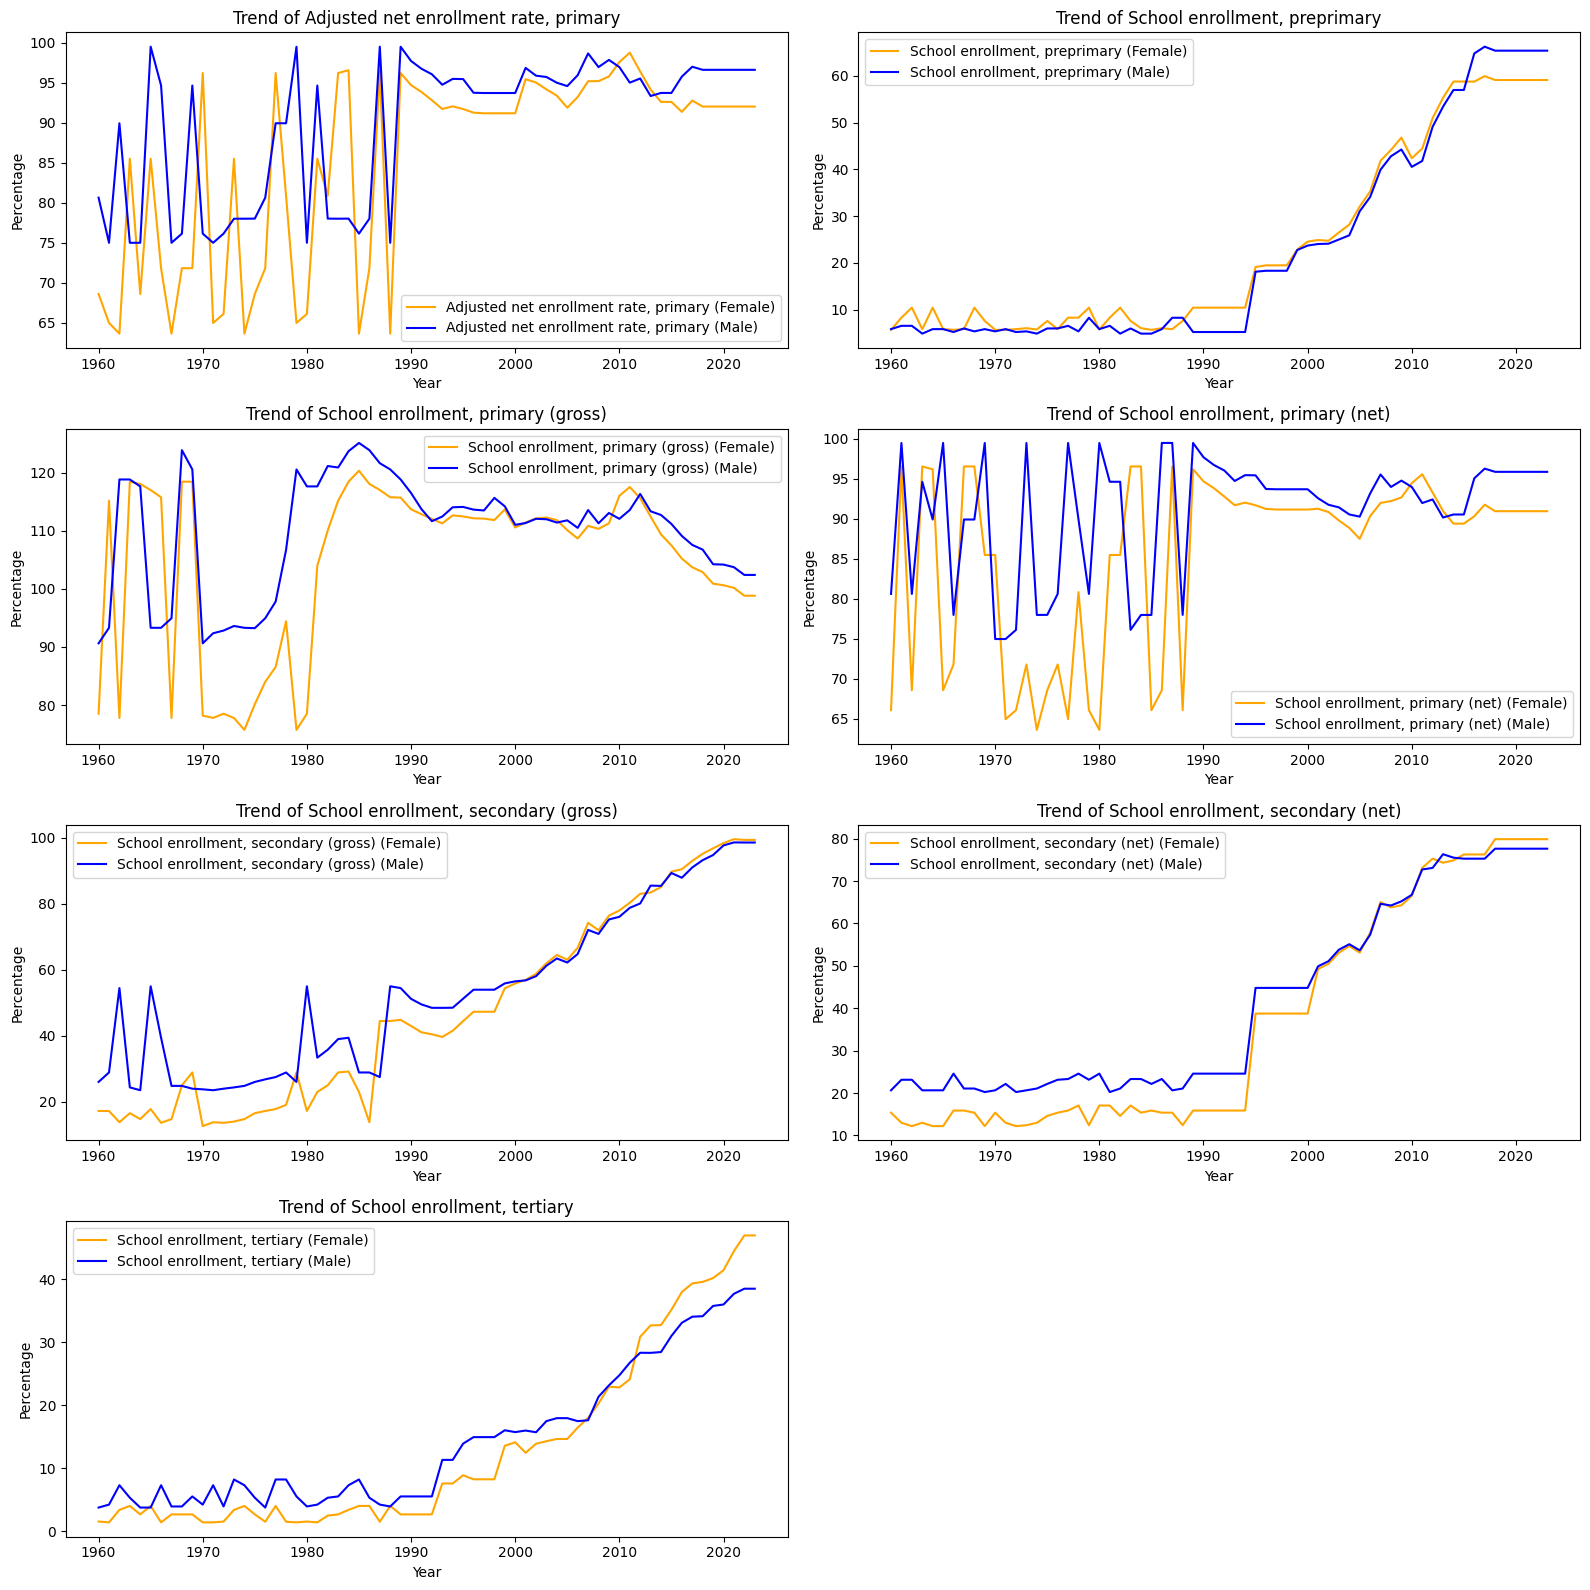

Cleaned dataset with disparity index has been exported to Cleaned_Gender_IDN_with_Disparity.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the normalized dataset
file_path = 'Imputed_Indicators_2.csv'
normalized_dataset = pd.read_csv(file_path)

# Define indicators
indicators = {
    'Adjusted net enrollment rate, primary': [
        'Adjusted net enrollment rate, primary, female (% of primary school age children)',
        'Adjusted net enrollment rate, primary, male (% of primary school age children)'
    ],
    'School enrollment, preprimary': [
        'School enrollment, preprimary, female (% gross)',
        'School enrollment, preprimary, male (% gross)'
    ],
    'School enrollment, primary (gross)': [
        'School enrollment, primary, female (% gross)',
        'School enrollment, primary, male (% gross)'
    ],
    'School enrollment, primary (net)': [
        'School enrollment, primary, female (% net)',
        'School enrollment, primary, male (% net)'
    ],
    'School enrollment, secondary (gross)': [
        'School enrollment, secondary, female (% gross)',
        'School enrollment, secondary, male (% gross)'
    ],
    'School enrollment, secondary (net)': [
        'School enrollment, secondary, female (% net)',
        'School enrollment, secondary, male (% net)'
    ],
    'School enrollment, tertiary': [
        'School enrollment, tertiary, female (% gross)',
        'School enrollment, tertiary, male (% gross)'
    ]
}

# Impute missing values using forward fill and backward fill
data_clean = normalized_dataset.fillna(method='ffill').fillna(method='bfill')

# Basic statistics
all_indicators = [indicator for sublist in indicators.values() for indicator in sublist]
data_stats = data_clean[all_indicators].describe()

# EDA: Visualize the trends
num_indicators = len(indicators)
num_rows = (num_indicators + 1) // 2  # Calculate the number of rows needed
plt.figure(figsize=(16, num_rows * 4))

for idx, (key, value) in enumerate(indicators.items()):
    plt.subplot(num_rows, 2, idx + 1)
    sns.lineplot(data=data_clean, x='Year', y=value[0], label=f'{key} (Female)', color='orange')
    sns.lineplot(data=data_clean, x='Year', y=value[1], label=f'{key} (Male)', color='blue')
    plt.title(f'Trend of {key}')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.legend()

plt.tight_layout()
plt.show()

# Calculate the disparity index for each pair of indicators
for key, value in indicators.items():
    if len(value) == 2:
        female_col = value[0]
        male_col = value[1]
        disparity_col = f'{key} Disparity'
        data_clean[disparity_col] = (data_clean[female_col] - data_clean[male_col]) / data_clean[male_col] * 100

# Calculate the disparity index for each set of indicators with multiple pairs
multi_pairs = {
    'School enrollment, primary (gross)': [
        'School enrollment, primary, female (% gross)',
        'School enrollment, primary, male (% gross)'
    ],
    'School enrollment, primary (net)': [
        'School enrollment, primary, female (% net)',
        'School enrollment, primary, male (% net)'
    ],
    'School enrollment, secondary (gross)': [
        'School enrollment, secondary, female (% gross)',
        'School enrollment, secondary, male (% gross)'
    ],
    'School enrollment, secondary (net)': [
        'School enrollment, secondary, female (% net)',
        'School enrollment, secondary, male (% net)'
    ]
}

for key, value in multi_pairs.items():
    female_col = value[0]
    male_col = value[1]
    disparity_col = f'{key} Disparity'
    data_clean[disparity_col] = (data_clean[female_col] - data_clean[male_col]) / data_clean[male_col] * 100

# Show the disparity index
disparity_columns = [f'{key} Disparity' for key in indicators.keys() if len(indicators[key]) == 2]
disparity_columns += [f'{key} Disparity' for key in multi_pairs.keys()]
disparity_data = data_clean[['Year'] + disparity_columns]

# Save the cleaned dataset with disparity index
output_file_path = 'Cleaned_Gender_IDN_with_Disparity.csv'
disparity_data.to_csv(output_file_path, index=False)
print(f'Cleaned dataset with disparity index has been exported to {output_file_path}')

Model for Adjusted net enrollment rate, primary Disparity:
  Mean Squared Error: 82.75982566648456
  R-squared: -0.6498986867689485



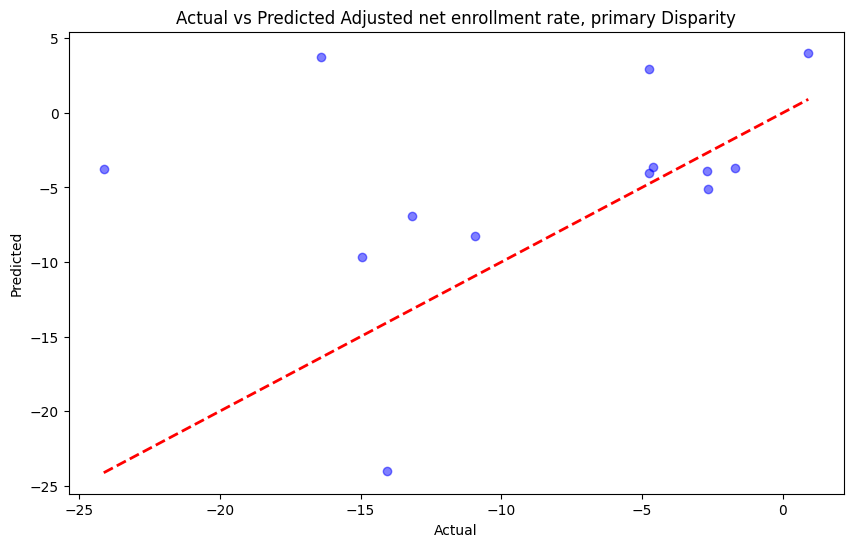

Model for School enrollment, preprimary Disparity:
  Mean Squared Error: 328.6136529887156
  R-squared: -1.6955261650612958



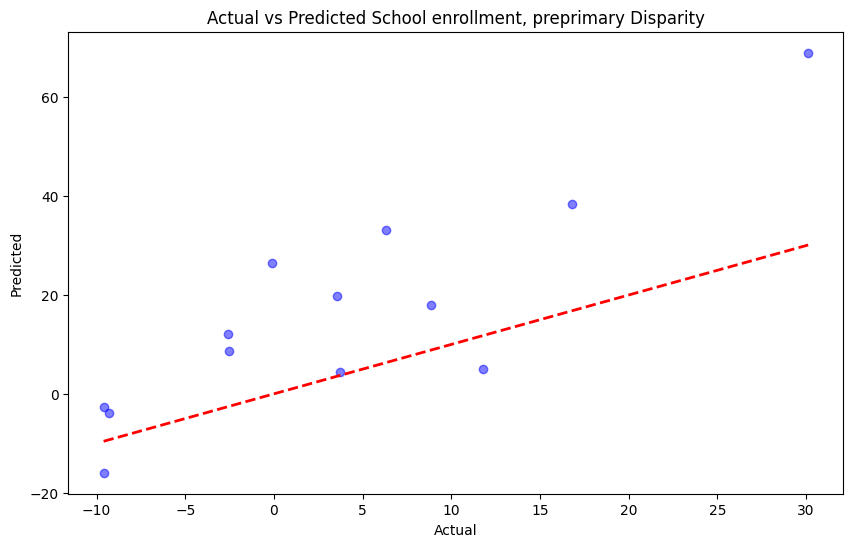

Model for School enrollment, primary (gross) Disparity:
  Mean Squared Error: 87.94887540547523
  R-squared: 0.022035258477413167



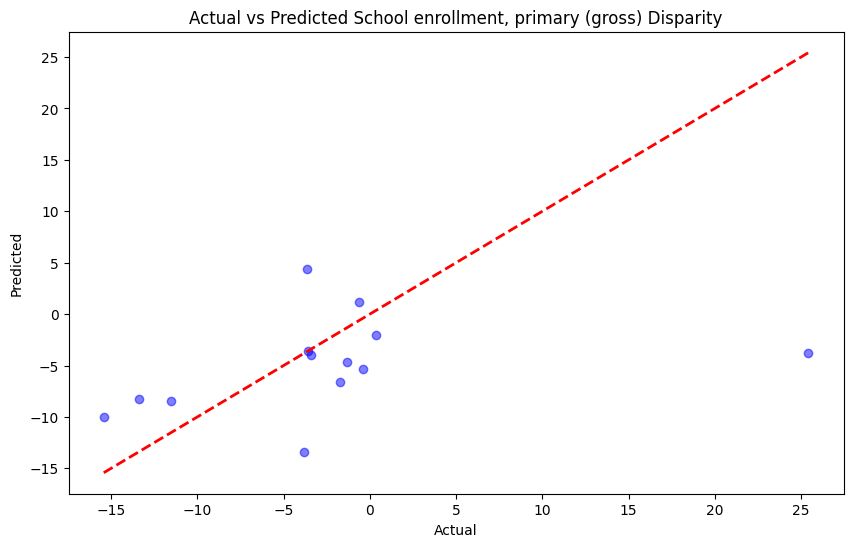

Model for School enrollment, primary (net) Disparity:
  Mean Squared Error: 72.25981426430408
  R-squared: -0.014057387562203205



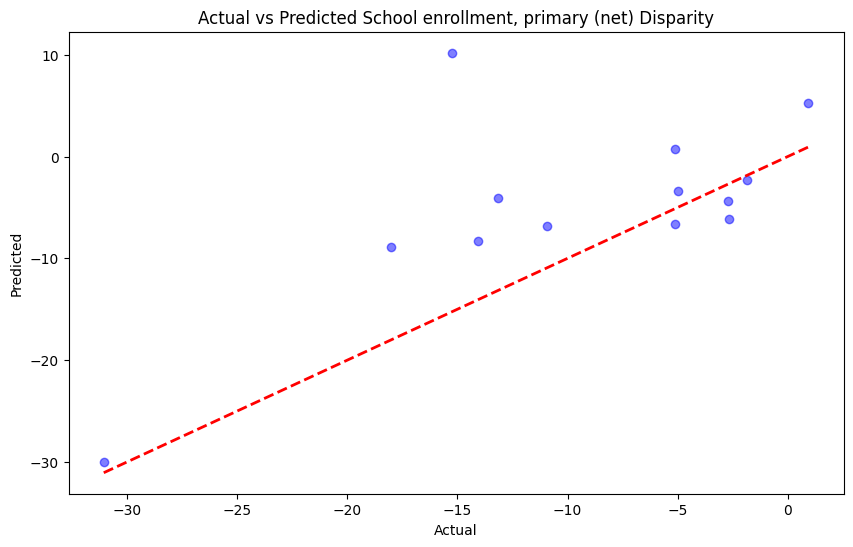

Model for School enrollment, secondary (gross) Disparity:
  Mean Squared Error: 140.65363328952122
  R-squared: 0.750826873016311



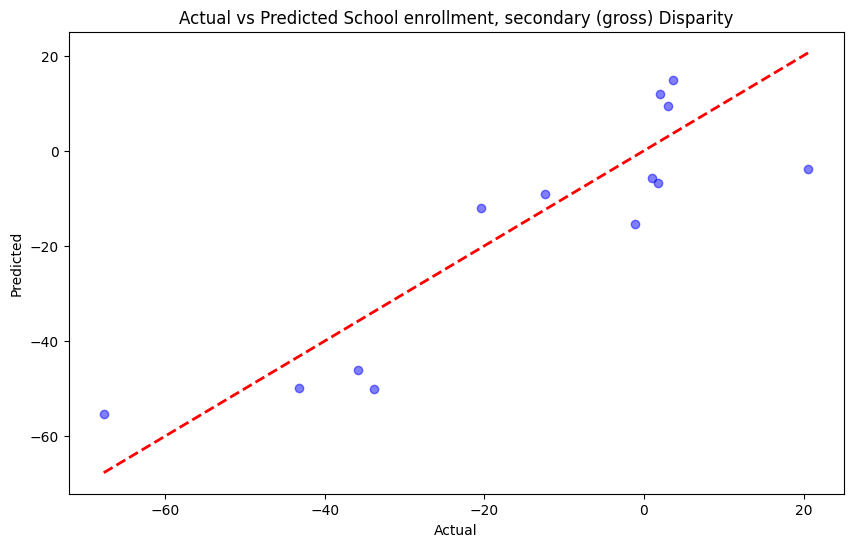

Model for School enrollment, secondary (net) Disparity:
  Mean Squared Error: 42.63694334397456
  R-squared: 0.8574851053150159



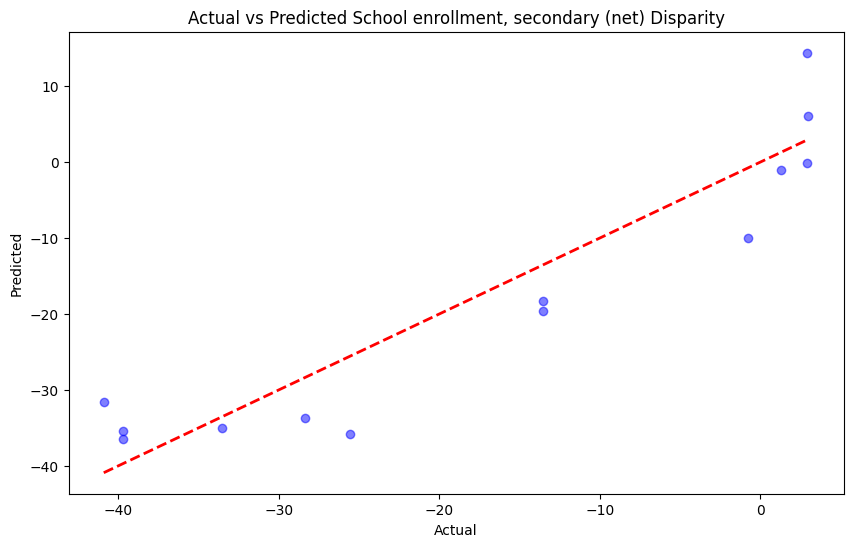

Model for School enrollment, tertiary Disparity:
  Mean Squared Error: 560.0416377901888
  R-squared: 0.4425145189683648



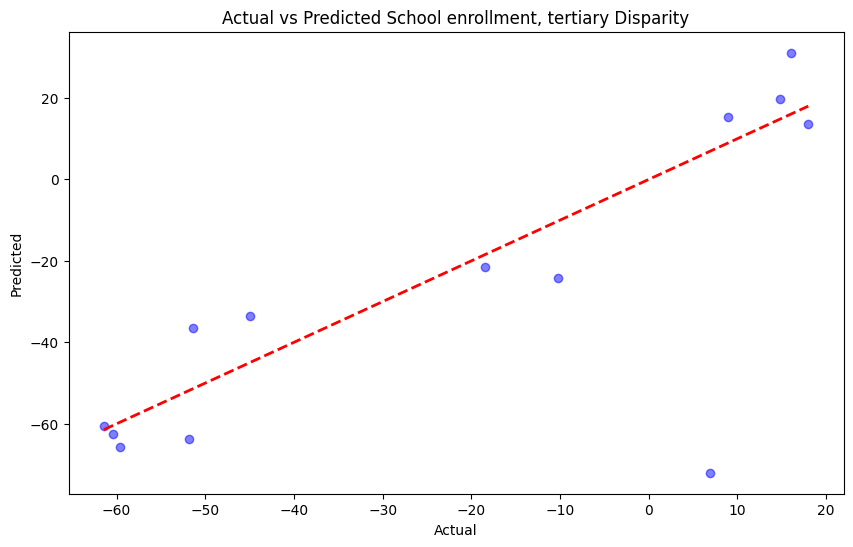

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the cleaned dataset with disparity index
file_path_disparity = 'Cleaned_Gender_IDN_with_Disparity.csv'
data_disparity = pd.read_csv(file_path_disparity)

# Load the original normalized dataset
file_path_original = 'Imputed_Indicators_2.csv'
data_original = pd.read_csv(file_path_original)

# Define features (X) based on columns in the original dataset
features = [
    'Adjusted net enrollment rate, primary, male (% of primary school age children)',
    'School enrollment, preprimary, male (% gross)',
    'School enrollment, primary, male (% gross)',
    'School enrollment, primary, male (% net)',
    'School enrollment, secondary, male (% gross)',
    'School enrollment, secondary, male (% net)',
    'School enrollment, tertiary, male (% gross)'
]

# Define targets (disparity indices) based on columns in the disparity dataset
targets = [
    'Adjusted net enrollment rate, primary Disparity',
    'School enrollment, preprimary Disparity',
    'School enrollment, primary (gross) Disparity',
    'School enrollment, primary (net) Disparity',
    'School enrollment, secondary (gross) Disparity',
    'School enrollment, secondary (net) Disparity',
    'School enrollment, tertiary Disparity'
]

# Impute missing values in the original dataset
imputer = SimpleImputer(strategy='mean')
data_original_imputed = pd.DataFrame(imputer.fit_transform(data_original), columns=data_original.columns)

# We will create a model for each target (disparity index)
models = {}
predictions = {}
for target in targets:
    # Prepare features and target
    X = data_original_imputed[features]
    y = data_disparity[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    models[target] = model

    # Make predictions
    y_pred = model.predict(X_test)
    predictions[target] = y_pred

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Model for {target}:')
    print(f'  Mean Squared Error: {mse}')
    print(f'  R-squared: {r2}')
    print()

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted {target}')
    plt.show()
